In [99]:
import wbdata
import pandas as pd
import numpy as np
import json
from openai import OpenAI
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import time
import warnings
import math
import re
from sklearn.linear_model import LinearRegression
from ast import literal_eval  #Is used to safely evaluate a string that looks like a Python literal 
import logging
logging.getLogger('shelved_cache.persistent_cache').setLevel(logging.ERROR) #Libraries warnings
warnings.filterwarnings('ignore') #Python warnings

In [100]:
import tiktoken

# Use OpenAI tokenizer to calculate token lengths (optional, more accurate)
def estimate_token_count(text, model="gpt-3.5-turbo-instruct"):
    enc = tiktoken.encoding_for_model(model)
    return len(enc.encode(text))

In [166]:
base_prompt  = """
You are a data scientist tasked with selecting the most relevant development indicators to predict when a country will reach the GDP per capita level of developed countries.

Below is a list of available indicators retrieved from the World Bank data source 2. Each item consists of an indicator code and its corresponding name:

{chunked_indicators}

Your task:
- Select indicators that are **strongly related to GDP growth**, **economic development**, or **structural transformation** (e.g. education, infrastructure, industrialization, trade, institutions).
- Prefer indicators that are **leading indicators** or have **causal influence** on development.
- Include indicators from diverse categories: macroeconomy, infrastructure, education, health, technology, labor, governance, etc.
- Limit your selection to {number_of_indicators_per_chunk} indicators.

Output format:
- Output a valid Python dictionary with the indicator code as key and a clean, abstract summary of the indicator meaning as the value.
- The indicator name must be cleaned of any special characters, keeping only letters, spaces, and the '%' sign.
- Do not include any code wrapping, comments, markdown formatting, or line breaks.
- Output only the dictionary on a single line like this:

dict_indicators = {{'CODE1': 'Abstract Indicator Name meaning 1','CODE2': 'Abstract Indicator Name meaning 2'}} """


In [167]:
available_indicators = wbdata.get_indicators(source=2)
# available_str = "\n".join([f"{i['id']}: {i['name']}" for i in available_indicators])
df_indicators = pd.DataFrame(available_indicators)[['id','name']]

enc = tiktoken.encoding_for_model("gpt-3.5-turbo-instruct")
df_indicators["token_count"] = df_indicators["name"].apply(lambda x: len(enc.encode(x)))

base_prompt_count = estimate_token_count(base_prompt)
model_max_tokens = 2500   # Model's maximum context length is 4097 tokens
max_prompt_tokens = model_max_tokens - base_prompt_count
chunk_index = []

for i in range(1,len(df_indicators)):
    if len(chunk_index) == 0:
        list_indicators = "\n".join((df_indicators["id"][0:i] + ": " + df_indicators["name"][0:i]).tolist())
        token_count = estimate_token_count(list_indicators)
    else:
        list_indicators = "\n".join((df_indicators["id"][current_index:i] + ": " + df_indicators["name"][current_index:i]).tolist())
        token_count = estimate_token_count(list_indicators)
    if token_count>max_prompt_tokens:
        current_index = i
        chunk_index.append(i)
        token_count = 0

list_indicators = (df_indicators["id"] + ": " + df_indicators["name"]).tolist()

chunks = [
    list_indicators[0:index] if i == 0 
    else list_indicators[chunk_index[i-1]:index]
    for i, index in enumerate(chunk_index)
]


In [168]:

# Load credentials
with open("credentials.json", "r") as file:
    credentials = json.load(file)

# Initialize the client
client = OpenAI(
    api_key=credentials["OPENAI_API_KEY"],
    base_url=credentials["OPENAI_API_BASE"]  # Only if using a proxy/alternative endpoint
)

# Decoding parameters
TEMPERATURE = 0.0
def query_openai(prompt):

    response = client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=TEMPERATURE,
        max_tokens=300  

    )
    time.sleep(5)  # rate limiting
    
    return response


In [169]:
max_indicators = 30
n_chunks =  len(chunks)
number_of_indicators_per_chunk = math.ceil(max_indicators/n_chunks)

merged_dict = {}

for idx, chunk in enumerate(chunks):
    print(f"\n Running chunk {idx+1}/{n_chunks}...")
    chunk_text = "\n".join(chunk)

    prompt = base_prompt.format(
        chunked_indicators=chunk_text,
        number_of_indicators_per_chunk=number_of_indicators_per_chunk
    )
    
    success = False
    retries = 3
    for attempt in range(1, retries + 1):
        try:
            print(f"Attempt {attempt}...", end=" ")
            response = query_openai(prompt)
            
            # extract dict with regex
            raw_text = response.choices[0].text.replace('\r', '').replace('\n', '').replace('\t', '').strip()

            match = re.search(r"\{.*?\}", raw_text, re.DOTALL)
            if not match:
                raise ValueError("No dictionary found in model response.")
            
            chunk_dict = literal_eval(match.group(0))
            merged_dict.update(chunk_dict)
            print("Success.")
            success = True
            break
        except Exception as e:

            print(f"Error: {e}")
            if attempt < retries:
                time.sleep(5)  # wait before retry
            else:
                print(f"Failed chunk {idx+1} after {retries} attempts.")




 Running chunk 1/15...
Attempt 1... Success.

 Running chunk 2/15...
Attempt 1... Success.

 Running chunk 3/15...
Attempt 1... Success.

 Running chunk 4/15...
Attempt 1... Success.

 Running chunk 5/15...
Attempt 1... Success.

 Running chunk 6/15...
Attempt 1... Success.

 Running chunk 7/15...
Attempt 1... Success.

 Running chunk 8/15...
Attempt 1... Success.

 Running chunk 9/15...
Attempt 1... Success.

 Running chunk 10/15...
Attempt 1... Success.

 Running chunk 11/15...
Attempt 1... Success.

 Running chunk 12/15...
Attempt 1... Error: No dictionary found in model response.
Attempt 2... Error: No dictionary found in model response.
Attempt 3... Success.

 Running chunk 13/15...
Attempt 1... Success.

 Running chunk 14/15...
Attempt 1... Success.

 Running chunk 15/15...
Attempt 1... Success.


In [170]:
america_countries = [
    'ARG', 'BLZ', 'BOL', 'BRA', 'CAN', 'CHL', 'COL', 
    'CRI', 'ECU', 'SLV', 'GTM', 'GUY', 'HND', 'MEX', 
    'NIC', 'PAN', 'PRY', 'PER', 'SUR', 'USA', 'URY'
]

# Adding target variable
merged_dict.update({'NY.GDP.PCAP.CD':'GDP per capita (current US$)'})

df = wbdata.get_dataframe(merged_dict, country=america_countries, parse_dates=True,date=("2000", "2025"))
df.reset_index(inplace = True)
# df.dropna(inplace=True)


In [344]:
def mull_heat_map(df,column_to_group):    
# Calculate null rate by country
    null_rates = df.groupby(column_to_group).apply(lambda x: x.isnull().mean())

    # The country is already the index, so we don't need to reset it
    # Just transpose the DataFrame for better visualization
    null_rates = null_rates.T  # This puts countries as columns and variables as rows

    # Create heatmap
    plt.figure(figsize=(20, 12))
    sns.heatmap(
        null_rates,
        cmap='YlOrRd',
        annot=True,
        fmt='.1%',
        linewidths=.5,
        cbar_kws={'label': 'Null Rate'}
    )

    plt.title('Null Rate by Date')
    plt.xlabel('Date')
    plt.ylabel('Variable')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

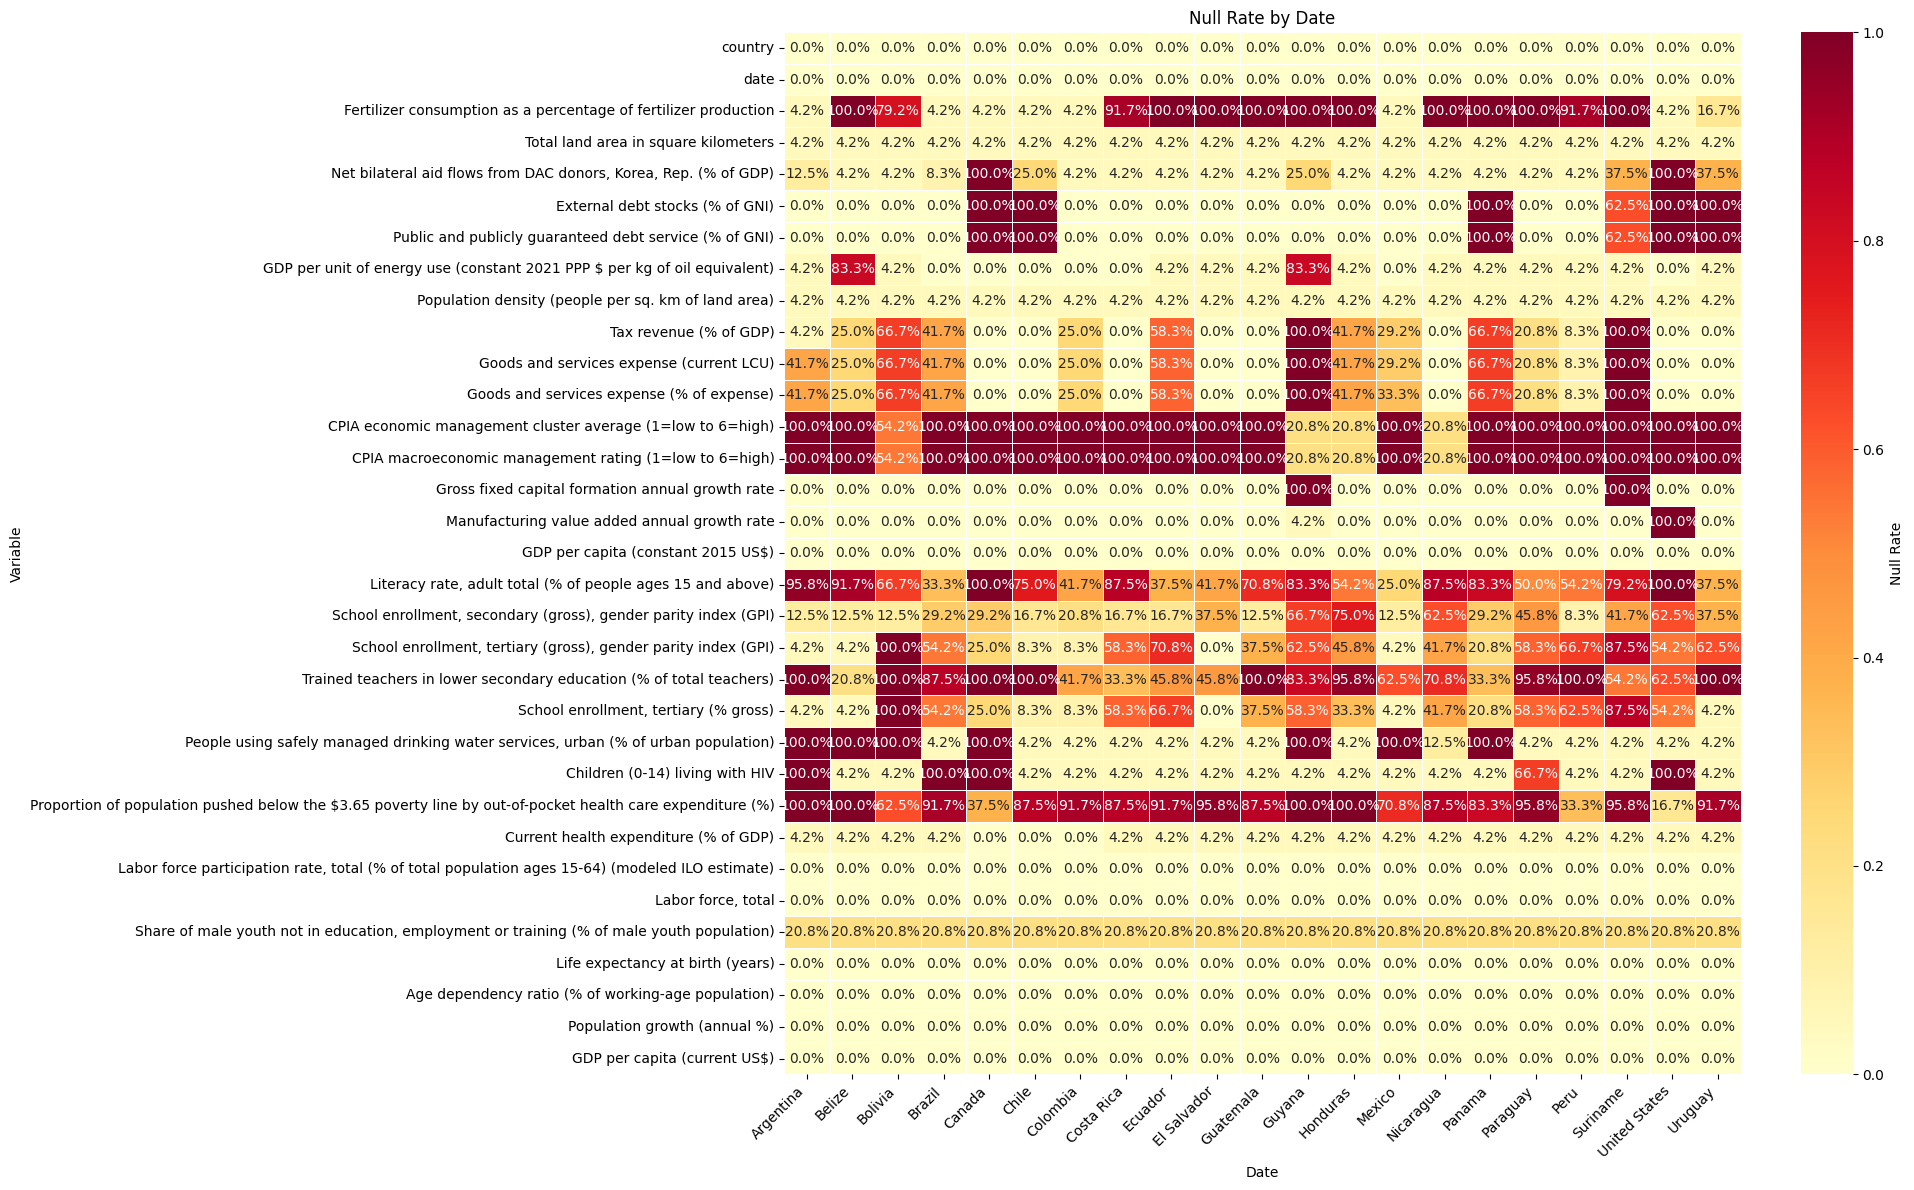

In [345]:
mull_heat_map(df,'country')

It is possible to see that the international migrant stock (% of popolation) isnt a god indicator, since most of its values are null

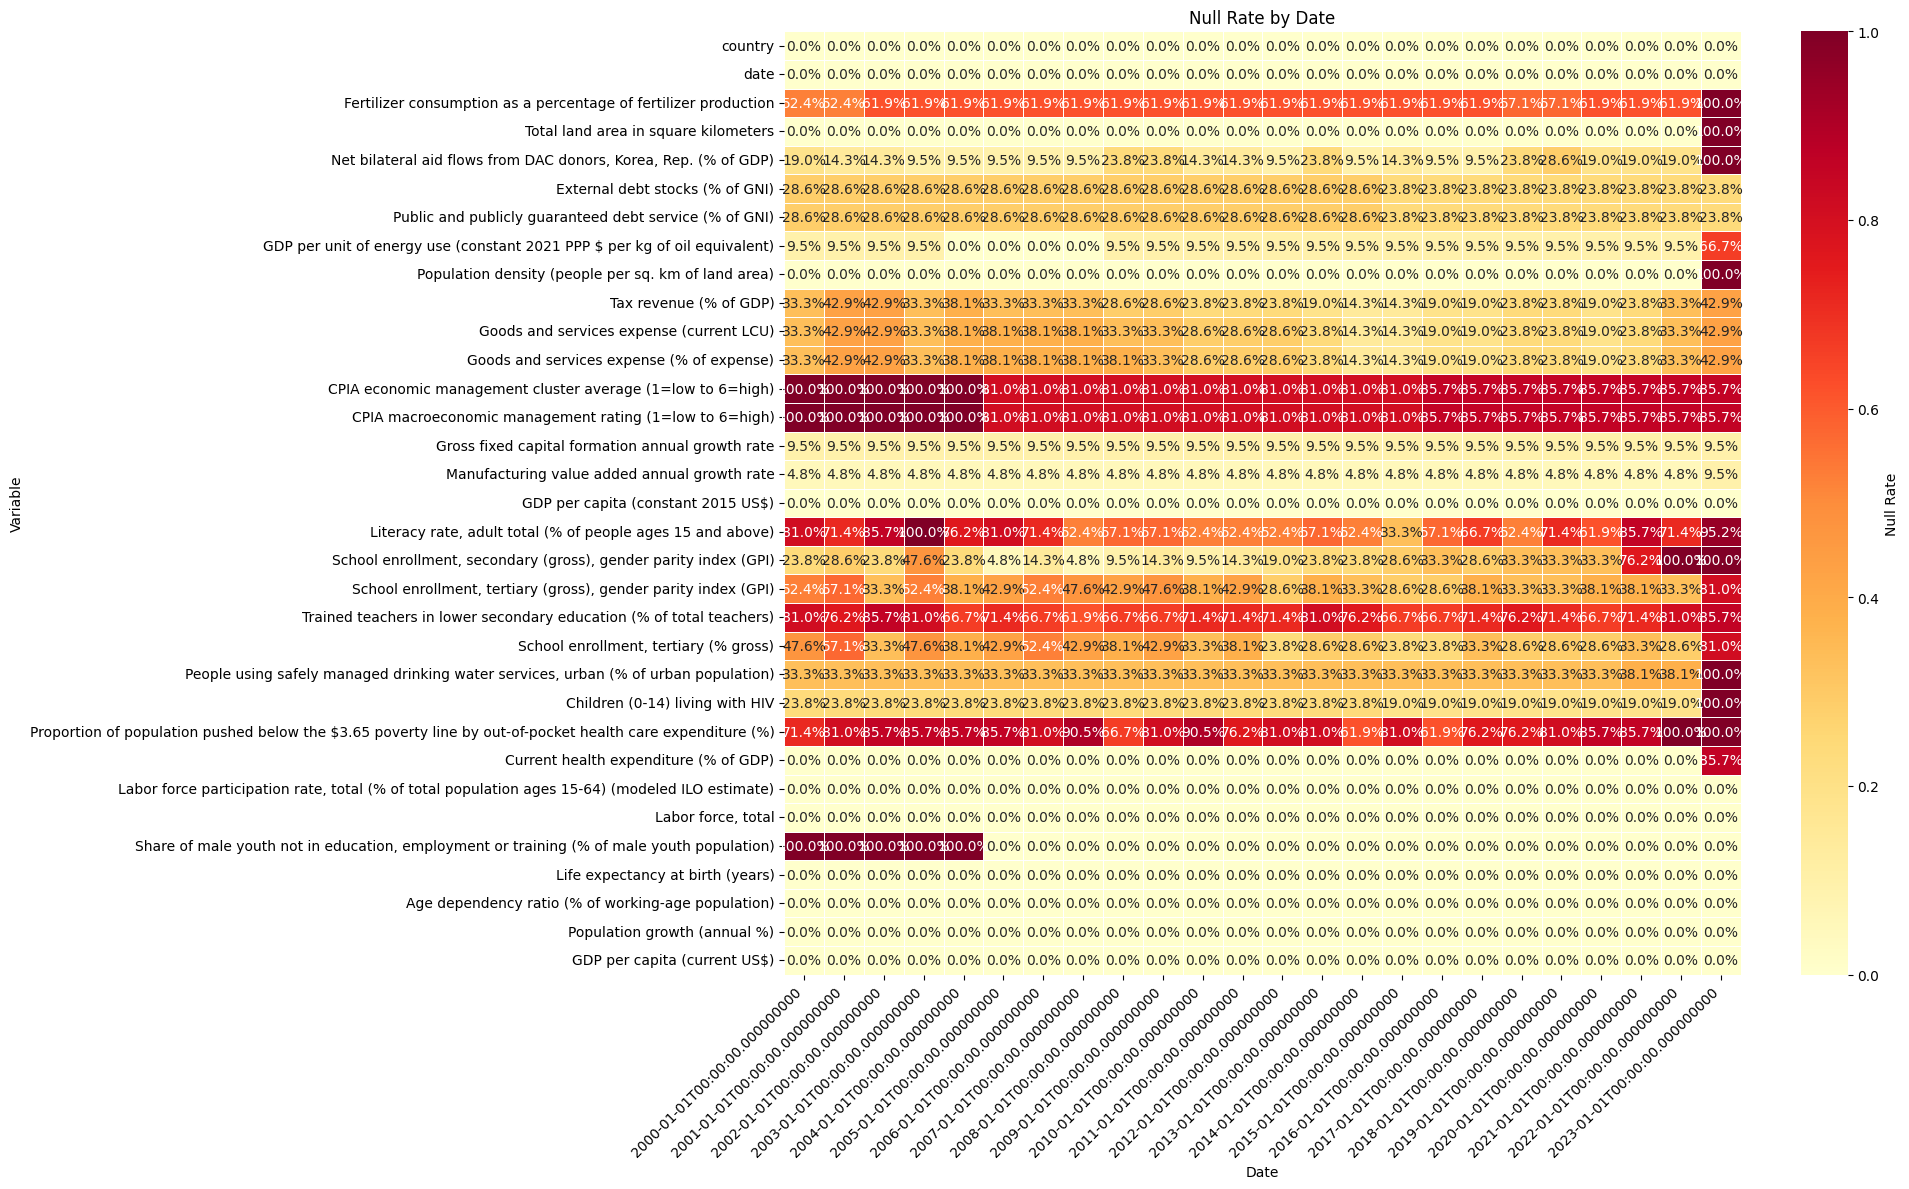

In [346]:
mull_heat_map(df,'date')

For this heat maps, we can see that the international migran stock indicator is not a good  indicator for us, since in many years we dont have any values in it, so we need to change that, furthermore we can remove that 2024 year from our data ser, for the same reason. 

In [335]:
threshold = 0.4  # % of missingness

df = df[df.date < '2024-01-01'] # to remove 2024 from the data set

null_rates_country = df.groupby(['country']).apply(lambda x: x.isnull().mean()).drop(columns = ['country'] ).reset_index()

columns_not_to_keep = []

for country in null_rates_country['country'].unique():
    country_data = null_rates_country[null_rates_country['country'] == country]
    
    for column in null_rates_country.columns[2:]:  # Skip 'country' and 'date'
        null_rate = country_data[column].values[0]  # Get the actual value (assumed to be a float)
        
        if null_rate > threshold:
            if column not in columns_not_to_keep:
                columns_not_to_keep.append(column)


In [336]:
columns_to_keep = [col for col in df.columns if col not in columns_not_to_keep]

print(f'Columns that have been dropped {columns_not_to_keep}')
print(f'Quantity of indicators dropped {len(columns_not_to_keep)} \nQuantity of keeped indicators {len(columns_to_keep)}')
df_filtered = df[columns_to_keep]

Columns that have been dropped ['Goods and services expense (current LCU)', 'Goods and services expense (% of expense)', 'CPIA economic management cluster average (1=low to 6=high)', 'CPIA macroeconomic management rating (1=low to 6=high)', 'Literacy rate, adult total (% of people ages 15 and above)', 'Trained teachers in lower secondary education (% of total teachers)', 'People using safely managed drinking water services, urban (% of urban population)', 'Children (0-14) living with HIV', 'Proportion of population pushed below the $3.65 poverty line by out-of-pocket health care expenditure (%)', 'Fertilizer consumption as a percentage of fertilizer production', 'GDP per unit of energy use (constant 2021 PPP $ per kg of oil equivalent)', 'Tax revenue (% of GDP)', 'School enrollment, tertiary (gross), gender parity index (GPI)', 'School enrollment, tertiary (% gross)', 'Net bilateral aid flows from DAC donors, Korea, Rep. (% of GDP)', 'External debt stocks (% of GNI)', 'Public and publi

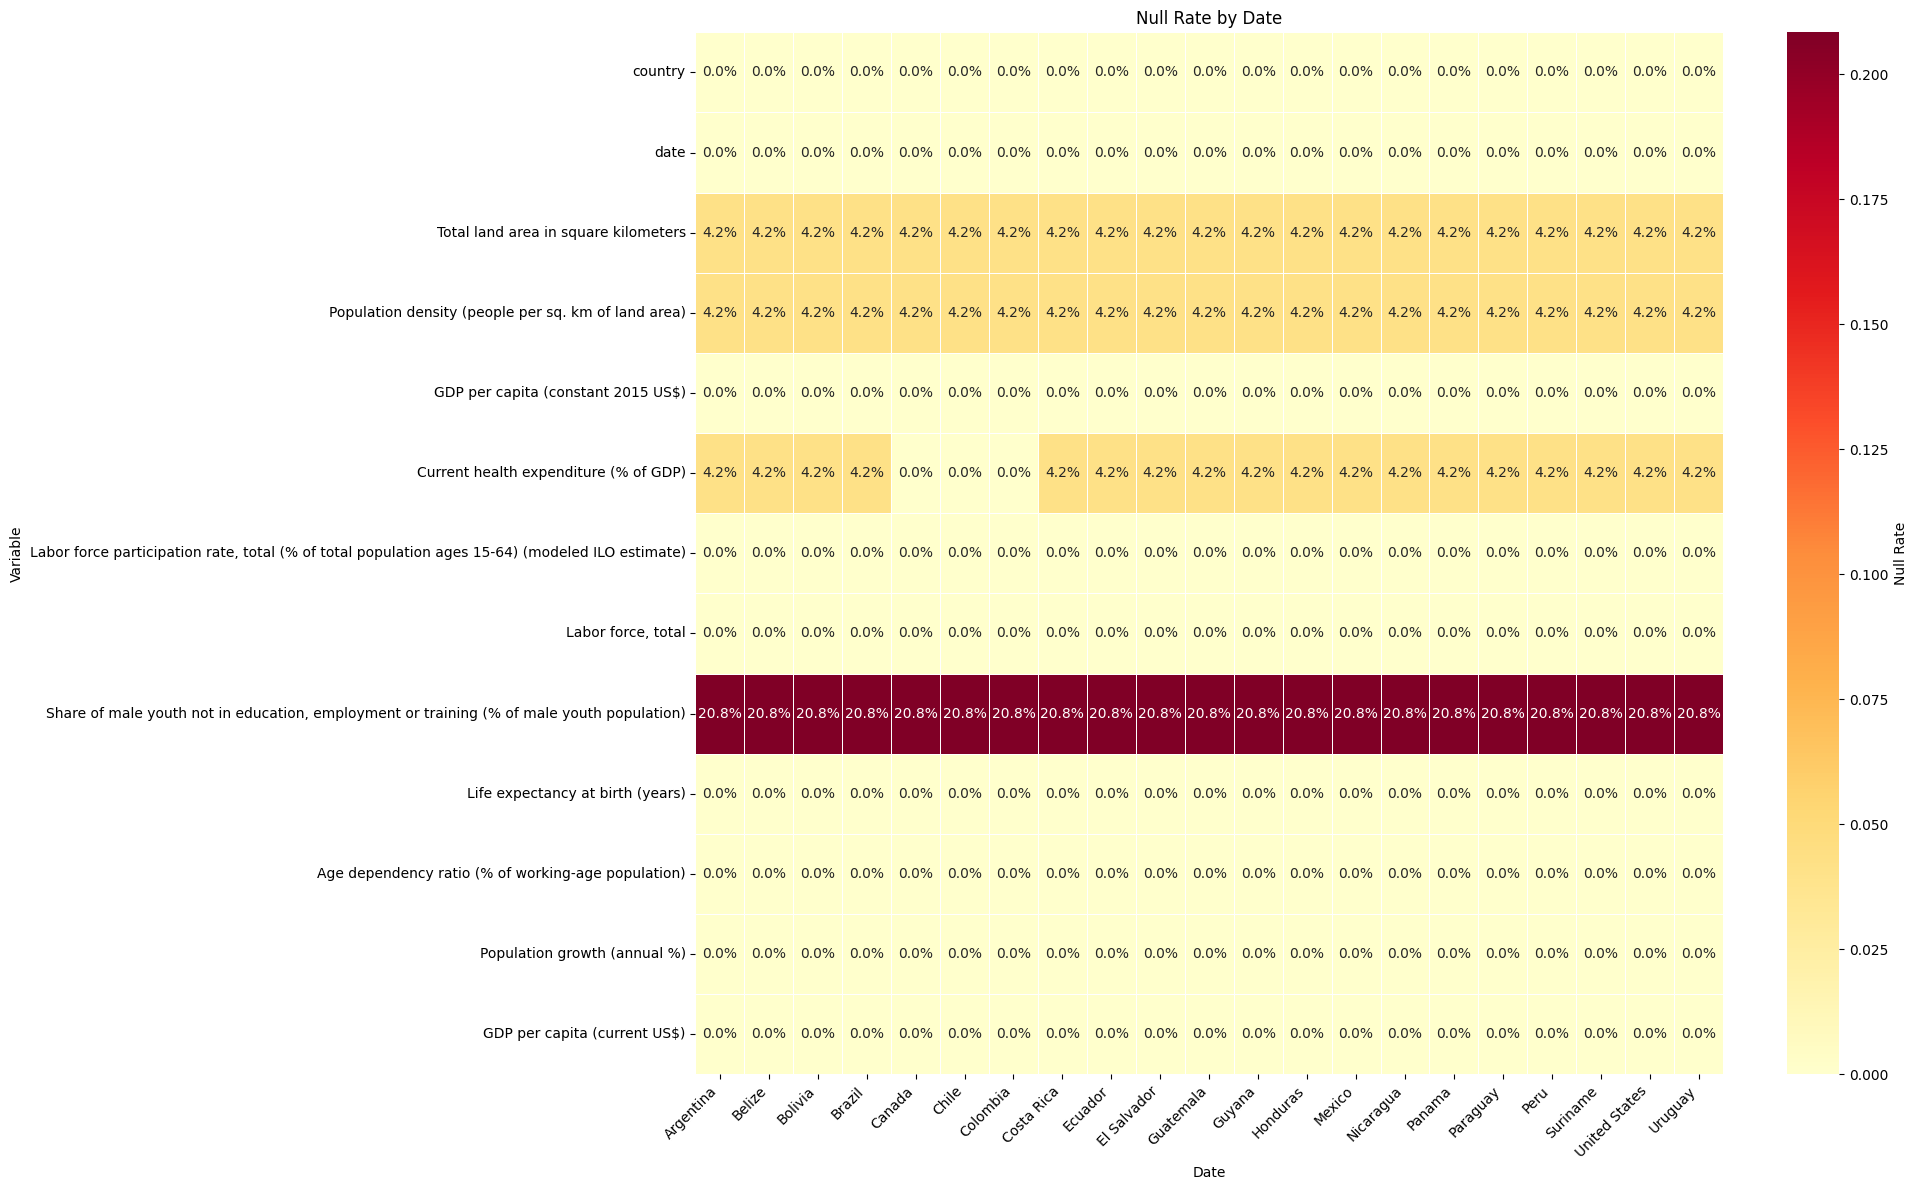

In [347]:
mull_heat_map(df_filtered,'country')

In [339]:
def imput_indicators_lr(df, country_col='country', year_col='date'):
    """
    Imputation using Lr
    
    Assumes:
    1. All indicator columns are numeric
    2. Year column is numeric
    3. Each country-indicator combo has ≥2 data points
    """
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    # Get indicator columns (exclude metadata)
    indicators = [col for col in df.columns 
                 if col not in {country_col, year_col}]
    
    # Single-pass imputation
    def impute_group(group):
        for col in indicators:
            # Get known values
            known = group[group[col].notna()]
            X = known[[year_col]]
            y = known[col]
            
            # Train and predict (no length checks needed)
            model = LinearRegression().fit(X, y)
            missing = group[col].isna()
            if missing.any():
                group.loc[missing, col] = model.predict(group.loc[missing, [year_col]])
        return group
    
    return df.groupby(country_col, group_keys=False).apply(impute_group)

In [340]:
df_filtered_imputed = imput_indicators_lr(df_filtered)